**Multidimensional endogenous grid point Method: Solving triangular dynamic stochastic Optimization problems without root-finding**

References: 
- Iskhakov, F. (2021). [Computational Economics Lecture](https://github.com/fediskhakov/CompEcon/blob/main/41_egm.ipynb).
- Iskhakov, F. (2015). Multidimensional endogenous gridpoint method: Solving triangular dynamic stochastic optimization problems without root-finding operations. Economics Letters, 135, 72-76.

QE Lunch Talk 2023-05-19 

# Simple EGM
Consider a well-defined consumption-saving problem
(1 controlled state + 1 uncontrolled state, 1 choice):

$$
V(M_t, y_t) = \max_{0 \leq c_t \leq M_t} \{u(c_t) + 
\beta \mathbb{E} \big(V(M_{t+1}, y_{t+1}) \mid y_t\big) \}.
$$

- $M_t$: wealth at $t$.
- $y_t$ : income at $t$ (included in $M_t$).
- $c_t$ : consumption during $t$.
- $r$: fixed net interest rate.
- Transition Rules: 
    - $M_{t+1} = (1+r)(M_t - c_t) + y_{t+1}$.
    - $y_{t}$ follows a Markov process.

## Euler Equation with Post-Decision States

- end-of-period wealth: $A_t = M_t - c_t(M_t)$.
- $ A_t $ contains all the information needed for the calculation of the expected value function in the next period, “sufficient statistic” for the current period state and choice.  
- $ A_t $ is often referred to as *post-decision state*.
- F.O.C. of r.h.s. of Bellman equation:
$$
u'(c_t) = \beta (1+r) \mathbb{E} \big( V^{\prime}_{1}\big(M_{t+1}, ~y_{t+1}\big) \mid y_t\big).
$$

- Envelope theorem:
$$
V_1^{\prime}(M_t, y_t) = \beta (1+r) \mathbb{E} \big( V_1^{\prime} (M_{t+1}, ~y_{t+1}) \mid y_t \big).
$$

- $u'(c_t) = V_1^{\prime}(M_t, y_t) \rightarrow u'(c_{t+1}) = V_1^{\prime}(M_{t+1}, y_{t+1})$.
Plug this back to F.O.C. we get the Euler equation.



- Euler equation:
$$
u'(c_t) = \beta (1+r) \mathbb{E} \big( u'(c_{t+1}) \mid y_t \big).
$$

- Denote the policy function as $c^{\star}$, we have:
$$
\begin{aligned}
u'\big(c^{\star}_t(M_t, y_t)\big) 
&= \beta (1+r) \mathbb{E} \big( u'\big(c^{\star}_{t+1} \big((1+r)[M_{t+1} - c^{\star}_{t}(M_t, y_t)] + y_{t+1} 
, ~y_{t+1} \big) \big) \mid y_t \big)\\
&= \beta (1+r) 
\mathbb{E} \big( u^{\prime}[c^{\star}_{t+1}\big((1+r)A_t + y_{t+1}, ~y_{t+1}\big)] \mid y_t \big).\\
\end{aligned}
$$

- $c_{t}^{\star}(M_t, y_t) = (u^{\prime})^{-1}\Big( \beta (1+r) \mathbb{E} \big( u^{\prime}[c_{t+1}^{\star}\big((1+r)A_t + y_{t+1}, ~y_{t+1}\big)] \mid y_t \big)\Big)$

## EGM Algorithm

1. Set grid points for states $(A, y)$.
1. Set initial policy function $c_{T}^{\star}(M, y)$.
1. For each grid point $(A_i, y_j)$, 
using the inverse marginal utility to get $c_{i, j}$.
1. Recover **endogenous** grid point $M_{i, j} = A_i + c_{i, j}$.
1. Update policy function $c_{T-1}^{\star}(M, y)$ using interpolation.
1. Repeat step 5 and 6 until $c^{\star}$ converges (infinite horizon) or $t=0$ (finite horizon).

## Implementation in Python
Let's return to the example, and consider the case $T=+\infty$.
We further assume:
- $\beta = 0.98$
- $u(c) = \log(c)$,
- $r = 0.0025$,
- $log(y_t) = 0.975 \log(y_{t-1}) + \varepsilon$, where $E(ɛ) = 0, Var(ɛ) = 0.49$. (We discretize the income process on a Markov chain.)

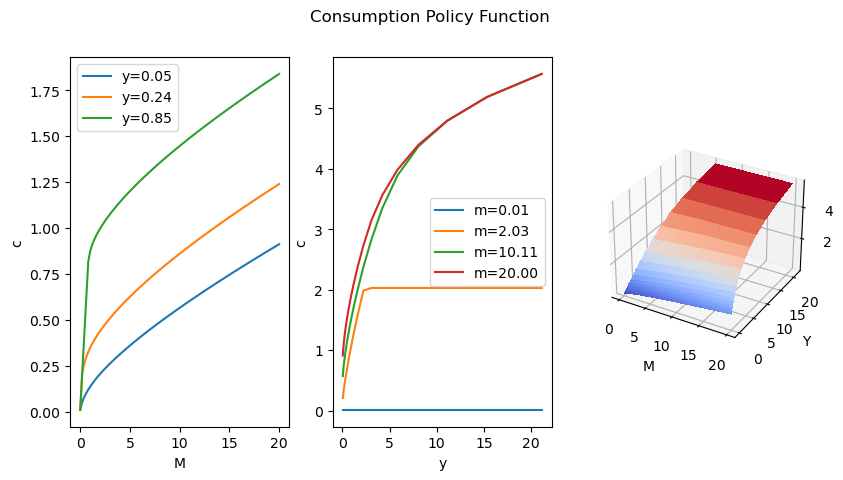

In [1]:
from egm_1d import egm_factory
# 100 wealth grids, 20 income grids
egm, draw_plot = egm_factory(β=0.98,
    r=0.0025,
    a_min=0.0,
    a_max=20.0,
    n_a=100,
    ρ=0.975,
    σ=0.7,
    n_y=20,)

p_c = egm(tol=1e-9)
draw_plot(p_c, y_index_list=[0, 5, 9], m_index_list=[0, 10, 50, 99])

# M-dimensional Triangular Dynamic Optimization problems

Consider the Bellman equation:
$$
V_{t}\left(X_{t}, s_{t}\right)= \max _{x_{t}}\left\{u\left(x_{t}, s_{t}\right)
+\beta E\left[V_{t+1}\left(X_{t+1}, s_{t+1}\right) \mid X_{t}, s_{t}, x_{t}\right]\right\},
$$
where $X_{t} \in \mathbb{R}^{M}, x_{t} \in \mathbb{R}^{M}$ and $s_{t} \in \mathbb{R}^{N}, t \in\{1, \ldots, T-1\}$, and the terminal policy function $\delta_{T}:\left(X_{T}, s_{T}\right) \rightarrow x_{T}$.

## Key Assumptions:
1. Transition rules for the continuous state variables $X_{t}^{1}, \ldots, X_{t}^{M}, j \in\{1, \ldots, M\}$ can be expressed in the form

$$
X_{t+1}^{j}=\chi^{j}\left(f^{1}\left(X_{t}^{1}, x_{t}^{1}, s_{t}\right), f^{2}\left(X_{t}^{1}, x_{t}^{1}, X_{t}^{2}, x_{t}^{2}, s_{t}\right), \ldots\right.
\left.f^{M}\left(X_{t}, x_{t}, s_{t}\right), s_{t}, s_{t+1}, \xi_{t+1}\right) \text {, }
$$

such that the post-decision states $f(t)=\left(f^{1}(t), \ldots, f^{M}(t)\right) \in \mathbb{R}^{M}$ admit the following structure:

$f^{1}(t)=f^{1}\left(X_{t}^{1}, x_{t}^{1}, s_{t}\right)$,

$f^{2}(t)=f^{2}\left(X_{t}^{1}, x_{t}^{1}, X_{t}^{2}, x_{t}^{2}, s_{t}\right)$,

...

$f^{M}(t)=f^{M}\left(X_{t}^{1}, x_{t}^{1}, \ldots, X_{t}^{M}, x_{t}^{M}, s_{t}\right)=f^{M}\left(X_{t}, x_{t}, s_{t}\right)$,

where $\chi^{j}(\cdot)$ and $f^{j}(\cdot)$ are deterministic differentiable functions, and $\frac{\partial f^{j}}{\partial x^{j}} \neq 0$ and $\frac{\partial f^{j}}{\partial X^{j}} \neq 0$, and $\frac{\partial f^{j}}{\partial x^{j}}$ is only dependent upon $f^1(t), \dots, f^j(t), s_t$; $\xi_{t+1} \in \mathbb{R}^{K}$ are idiosyncratic shocks.

2. There exist permutations $k^{1}=\left(k_{(1)}^{1}, \ldots, k_{(M)}^{1}\right)$ and $k^{2}=\left(k_{(1)}^{2}, \ldots, k_{(M)}^{2}\right)$ of the natural numbers 1 to $M$ such that if $J_{k^{1}}$ and $J_{k^{2}}$ are the corresponding permutation matrices and $H$ is the Hessian of the utility function $u\left(x_{t}, s_{t}\right)$ for a fixed $s_{t}$, it holds that the permuted Hessian $H^{P}=J_{k^{1}} H J_{k^{2}}$ is lower triangular, the diagonal elements of $H^{P}$ are non-zero, the partial derivatives $\frac{\partial u\left(x_{t}, s_{t}\right)}{\partial x_{t}^{i}}$ are strictly monotone in $x_{t}^{j}$, and their inverses in $x_{t}^{j}$ have analytical forms.

## Derivation of the Euler equations

F.O.C. w.r.t. $x^j_t$:
$$
\begin{aligned}
& \quad\quad u_{x^{j}}^{\prime}\left(x_{t}, s_{t}\right)+\beta \sum_{i=1}^{M} E\left[\frac{\partial V_{t+1}\left(X_{t+1}, s_{t+1}\right)}{\partial X_{t+1}^{i}}\right. 
 \left.\times \sum_{k=j}^{M}\left(\frac{\partial \chi^{i}}{\partial f^{k}} \frac{\partial f^{k}(t)}{\partial x_{t}^{j}}\right) \mid s_{t}, f(t)\right]=0 \\
& \Longrightarrow u_{x^{j}}^{\prime}\left(x_{t}, s_{t}\right)+\beta \sum_{k=j}^{M} \frac{\partial f^{k}(t)}{\partial x_{t}^{j}} 
 \times E\left[\sum_{i=1}^{M} \frac{\partial V_{t+1}\left(X_{t+1}, s_{t+1}\right)}{\partial X_{t+1}^{i}} \frac{\partial \chi^{i}}{\partial f^{k}} \mid s_{t}, f(t)\right]=0 . \\
\end{aligned}
$$


Envelope condition w.r.t. $X^j_t$:
$$
\begin{aligned}
\frac{\partial V_{t}\left(X_{t}, s_{t}\right)}{\partial X_{t}^{j}}&=\beta \sum_{i=1}^{M} E\left[\frac{\partial V_{t+1}\left(X_{t+1}, s_{t+1}\right)}{\partial X_{t+1}^{i}}\right.
\left.\times \sum_{k=j}^{M}\left(\frac{\partial \chi^{i}}{\partial f^{k}} \frac{\partial f^{k}(t)}{\partial X_{t}^{j}}\right) \mid s_{t}, f(t)\right] \\
& =\beta \sum_{k=j}^{M} \frac{\partial f^{k}(t)}{\partial X_{t}^{j}} 
\times E\left[\sum_{i=1}^{M} \frac{\partial V_{t+1}\left(X_{t+1}, s_{t+1}\right)}{\partial X_{t+1}^{i}} \frac{\partial \chi^{i}}{\partial f^{k}} \mid s_{t}, f(t)\right].\\
\end{aligned}
$$

Denote 
$\phi_{t}^{j}=\frac{\partial f^{j}(t)}{\partial X_{t}^{j}} / \frac{\partial f^{j}(t)}{\partial x_{t}^{j}}$,
then combine the two equations above for $j = M$, we have:
$$
\frac{\partial V_{t}\left(X_{t}, s_{t}\right)}{\partial X_{t}^{M}}=-\phi_{t}^{M} u_{x^{M}}^{\prime}\left(x_{t}, s_{t}\right)
$$


Take the differences of the F.O.C. and Envelop condition between $j$ and $j+1$ respectively, we have:

$$
\begin{aligned}
& u_{\chi^{j}}^{\prime}\left(x_{t}, s_{t}\right)-u_{\chi^{j+1}}^{\prime}\left(x_{t}, s_{t}\right)+\beta \frac{\partial f^{j}(t)}{\partial x_{t}^{j}} 
 \times E\left[\sum_{i=1}^{M} \frac{\partial V_{t+1}\left(X_{t+1}, s_{t+1}\right)}{\partial X_{t+1}^{i}} \frac{\partial \chi^{i}}{\partial f^{j}} \mid s_{t}, f(t)\right]=0, \\
& \frac{\partial V_{t}\left(X_{t}, s_{t}\right)}{\partial X_{t}^{j}}-\frac{\partial V_{t}\left(X_{t}, s_{t}\right)}{\partial X_{t}^{j+1}} 
 =\beta \frac{\partial f^{j}(t)}{\partial X_{t}^{j}} E\left[\sum_{i=1}^{M} \frac{\partial V_{t+1}\left(X_{t+1}, s_{t+1}\right)}{\partial X_{t+1}^{i}} \frac{\partial \chi^{i}}{\partial f^{j}} \mid s_{t}, f(t)\right],
\end{aligned}
$$

Thus, for $j = 1, \dots M-1$:
$\frac{\partial V_{t}\left(X_{t}, s_{t}\right)}{\partial X_{t}^{j}}=\frac{\partial V_{t}\left(X_{t}, s_{t}\right)}{\partial X_{t}^{j+1}}+\phi_{t}^{j}\left[u_{\chi^{j+1}}^{\prime}\left(x_{t}, s_{t}\right)-u_{\chi^{j}}^{\prime}\left(x_{t}, s_{t}\right)\right]$.

Combining this with 
$
\frac{\partial V_{t}\left(X_{t}, s_{t}\right)}{\partial X_{t}^{M}}=-\phi_{t}^{M} u_{x^{M}}^{\prime}\left(x_{t}, s_{t}\right)
$,
We have 
$$
\frac{\partial V_{t}\left(X_{t}, s_{t}\right)}{\partial X_{t}^{j}}=-\phi_{t}^{j} u_{x^{j}}^{\prime}\left(x_{t}, s_{t}\right)-\sum_{i=j+1}^{M}\left(\phi_{t}^{i}-\phi_{t}^{i-1}\right) u_{x^{i}}^{\prime}\left(x_{t}, s_{t}\right).
$$
Plug this into F.O.C., we get the Euler equations.

## Euler Equations
$u_{x^{j}}^{\prime}\left(x_{t}, s_{t}\right)=\beta \sum_{k=j}^{M} \frac{\partial f^{k}(t)}{\partial x_{t}^{j}} E\left[\sum_{i=1}^{M} \frac{\partial \chi^{i}}{\partial f^{k}} \mathcal{L}_{t+1}^{i} \mid s_{t}, f(t)\right]$

where $j \in\{1, \ldots, M\}$ and $\mathcal{L}_{t+1}^{i}$ is a linear function of marginal utilities evaluated at the optimal decisions in period $t+1$

$$
\mathcal{L}_{t+1}^{i} =
\begin{cases}
\phi^{i}_{t+1} u_{x^{i}}^{\prime}\left(x_{t+1}, s_{t+1}\right) 
 +\sum_{k=i+1}^{M}\left(\phi^{k}_{t+1} - \phi^{k-1}_{t+1} \right) u_{x^{k}}^{\prime}\left(x_{t+1}, s_{t+1}\right) \text{ if } j < M,\\
\phi^{M}_{t+1} u_{x^{M}}^{\prime}\left(x_{t+1}, s_{t+1}\right) \text{ if } j = M.
\end{cases}
$$

where $\phi_{t}^{j}=\frac{\partial f^{j}(t)}{\partial X_{t}^{j}} / \frac{\partial f^{j}(t)}{\partial x_{t}^{j}}$.

## M-Dimensional EGM Algorithm
1. Initialize the policy function.
1. Set M-dim grid points for post decision states.
1. Use Euler equations to get M equations of marginal utilities w.r.t M choices.
1. Solve choice variables by exploiting the *triangular structure* of the Hessian matrix of utility function.
1. Solve M endogenous state variables by exploiting the structure of post state variable 
functions $f(t)$.
1. Update the policy function.
1. Repeat until policy function converges (infinite horizon) or $t=0$ (finite horizon).

## Three-dimensional Example

Consider an infinite horizon consumption-saving model with working and learning time choices:
$$
V(E_{t}, Q_{t}, M_{t}, w_t) = \max_{h_t, l_t, c_t}
\Big\{
u^1(h_t) + u^2(l_t) + u^3(c_t) 
+ \beta \mathbb{E} V(E_{t+1}, Q_{t+1}, M_{t+1}, w_{t+1} \mid w_t) \Big\}
$$

- State Variables:
    - $E_t$: working experience.
    - $Q_t$: knowledge.
    - $M_t$: wealth.
    - $w_t$: market wage for one unit of efficient labor.
- Choice Variables:
    - $h_t$: working time.
    - $l_t$: learning time.
    - $c_t$: consumption.

Transition Rules:
- $E_{t+1} = a_1 E_t + a_2 h_t$
- $Q_{t+1} = b_1 Q_t + b_2 l_t$
- $M_{t+1} = (1+r)(M_t - c_t) + w_{t+1} Q_{t+1}^{\gamma} E_{t+1}^{1 - \gamma}$

Post Decision States:
- $f^{1}(t) = E_{t+1}$
- $f^{2}(t) = Q_{t+1}$
- $f^{3}(t) = A_t = M_t - c_t$

## Implementation in Python (it needs to be improved.)
Let's return to the example, and consider the case $T=+\infty$.
We further assume:
- $\beta = 0.98$.
- $u^1(h) = -e^h, ~ u^2(l) = -e^l, u^3(c) = \log(c)$, 
- $r = 0.1$,
- $a_1 = 0.3, a_2 = 1, b_1 = 0.3, b_2 = 1, \gamma=0.3$
- $log(w_t) = 0.975 \log(w_{t-1}) + \varepsilon$, where $E(ɛ) = 0, Var(ɛ) = 0.16$. (We discretize the income process on a Markov chain.)

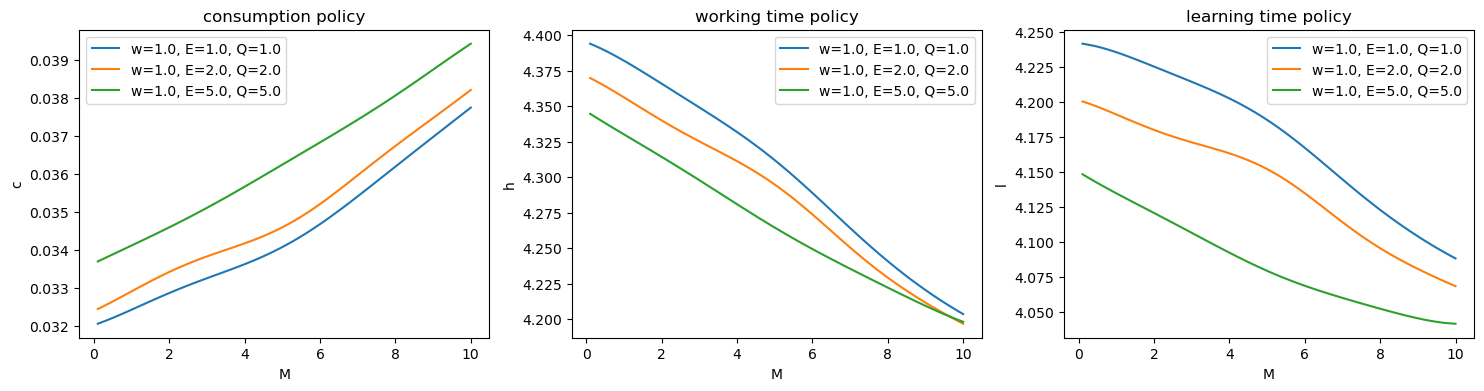

In [1]:
from egm_3d import egm3d_factory
egm_3d, egm_3d_plot = egm3d_factory(n_a=20, n_e=5, n_q=5, n_w=3, ρ=0.975, σ=0.4, γ=0.3)
policy = egm_3d(tol=1e-3)

import numpy as np
egm_3d_plot(policy, m_list = np.linspace(0.1, 10, 100))